In [2]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=0)

View data

In [3]:
import pandas as pd

circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "Label": y,
})
circles.head()

,X1,X2,Label
0,0.809935,-0.053514,1
1,-0.134486,-0.742095,1
2,-0.812506,-0.624244,0
3,0.583074,0.496568,1
4,-0.461320,0.659836,1


Visualize

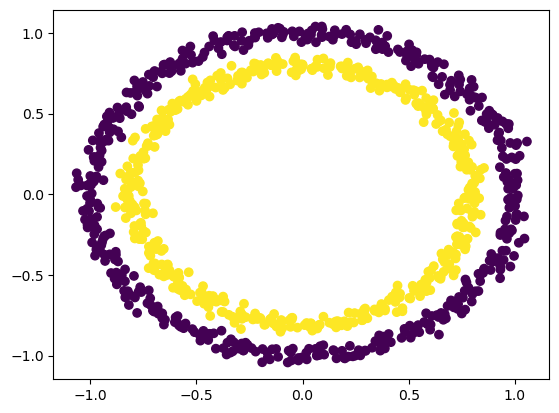

In [4]:
import matplotlib.pyplot as plt
plt.scatter(
    x=X[:, 0],
    y=X[:, 1],
    c=y
)

Turning data to tensor and split the data to train and test set

In [38]:
import torch
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.__version__

'2.3.0'

In [6]:
X = torch.from_numpy(X).type(torch.float16)
y = torch.from_numpy(y).type(torch.float16)

X[:5], y[:5]

(tensor([[ 0.8101, -0.0535],
         [-0.1345, -0.7422],
         [-0.8125, -0.6240],
         [ 0.5830,  0.4966],
         [-0.4614,  0.6597]], dtype=torch.float16),
 tensor([1., 1., 0., 1., 1.], dtype=torch.float16))

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
len(X_train), len(X_test)

(800, 200)

In [8]:
from torch import nn

Create model

Option 1:

In [9]:
class CircleModel_0(nn.Module):
    def __init__(self,) -> None:
        super().__init__()
        self.layer_1 = nn.Linear(2, 5)
        self.layer_2 = nn.Linear(5,1)
    
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
model_0 = CircleModel_0().to(device)
model_0

CircleModel_0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

Option 2

In [26]:
model_0 = nn.Sequential(
    nn.Linear(2, 5, dtype=torch.float16),
    nn.Linear(5, 1, dtype=torch.float16),
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

Option 3

In [13]:
class CircleModel_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.two_linear_layer = nn.Sequential(
            nn.Linear(2, 5, dtype=torch.float16),
            nn.Linear(5, 1, dtype=torch.float16),
        )
    
    def forward(self, x):
        return self._two_linear_layer(x)

In [14]:
model_0 = CircleModel_1().to(device)
model_0.state_dict()

OrderedDict([('two_linear_layer.0.weight',
              tensor([[-0.3855, -0.6173],
                      [-0.6485, -0.5199],
                      [-0.6188, -0.3859],
                      [-0.5446,  0.1923],
                      [ 0.3033,  0.1007]], device='cuda:0')),
             ('two_linear_layer.0.bias',
              tensor([-0.2760, -0.2782, -0.2063,  0.6232, -0.0905], device='cuda:0')),
             ('two_linear_layer.1.weight',
              tensor([[-0.1466,  0.4352, -0.0411,  0.2658,  0.2594]], device='cuda:0')),
             ('two_linear_layer.1.bias', tensor([0.3969], device='cuda:0'))])

Loss Function and Optimizer

In [18]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [19]:
def accuracy_fn(y, y_pred):
    correct = torch.eq(y_pred, y).sum().item()
    return (correct / len(y_pred)) * 100

Try it out!

In [36]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.6074],
        [0.4849],
        [0.4382],
        [0.5679],
        [0.4434]], device='cuda:0', dtype=torch.float16)

In [37]:
torch.sigmoid(y_logits)

tensor([[0.6475],
        [0.6187],
        [0.6079],
        [0.6382],
        [0.6089]], device='cuda:0', dtype=torch.float16)

In [ ]:
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_logits)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if epoch % 10 == 0:
        model_0.eval()
        with torch.inference_mode():
            test_logits = model_0(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(model_0(X_test).squeeze()))

            test_loss = loss_fn(test_logits, y_test)

            test_acc = accuracy_fn(y_test, test_pred)
